# Quantum Fourier Transform

While not my favorite quantum computing experiment, it was the coolest thing I found that I could actually implement. Actual implememntation was my own (supported by digging through qiskit documentation),and theory and circuit layout based on https://en.wikipedia.org/wiki/Quantum_Fourier_transform

In [1]:
import numpy as np
from numpy import pi
# importing Qiskit
import qiskit as q
from qiskit import QuantumCircuit, transpile, assemble, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector

The discrete Fourier transform acts on a vector $(x_0, ..., x_{N-1})$ and maps it to the vector $(y_0, ..., y_{N-1})$ according to the formula


$$y_k = \frac{1}{\sqrt{N}}\sum_{n=0}^{N-1}x_n\omega_N^{-kn}, \;\; k=0,1,2,N-1$$


where ${\omega_N} = e^{\frac{2\pi i }{N}}$ and ${\omega_N^n}$ in an $N^{th}$ root of unity.

Similarly, the quantum Fourier transform acts on a quantum state $\sum_{i=0}^{N-1} x_i \vert i \rangle$ and maps it to the quantum state $\sum_{i=0}^{N-1} y_i \vert i \rangle$ according to the formula


$$y_k = \frac{1}{\sqrt{N}}\sum_{n=0}^{N-1}x_n\omega_N^{nk}, \;\; k=0,1,2,N-1$$


This can also be expressed as the map:


$$\vert x \rangle \mapsto \frac{1}{\sqrt{N}}\sum_{y=0}^{N-1}\omega_N^{xy} \vert y \rangle$$



Or the unitary matrix:


$$ U_{QFT} = \frac{1}{\sqrt{N}} \sum_{x=0}^{N-1} \sum_{y=0}^{N-1} \omega_N^{xy} \vert y \rangle \langle x \vert$$


The steps to creating the circuit for $\vert y_3y_2y_1\rangle = QFT\vert x_3x_2x_1\rangle$ would be:

<ol>
<li> Apply a Hadamard gate to $\vert x_1 \rangle$

$$
\psi_1 = 
\vert x_3\rangle
\otimes
\vert x_2\rangle
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle + 
\exp\left(\frac{2\pi i}{2}x_1\right) 
\vert1\rangle\right]
$$

<li> Apply a $UROT_2$ gate to $\vert x_1\rangle$ depending on $\vert x_2\rangle$

$$
\psi_2 = 
\vert x_3\rangle
\otimes
\vert x_2\rangle
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^2}x_2 + \frac{2\pi i}{2}x_1
\right) 
\vert1\rangle\right]
$$

<li> Apply a $UROT_3$ gate to $\vert x_1\rangle$ depending on $\vert x_3\rangle$

$$
\psi_3 = 
\vert x_3\rangle
\otimes
\vert x_2\rangle
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^3}x_3 + \frac{2\pi i}{2^2}x_2 + \frac{2\pi i}{2}x_1
\right) 
\vert1\rangle\right]
$$

<li> Apply a Hadamard gate to $\vert x_2 \rangle$

$$
\psi_4 = 
\vert x_3\rangle
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2}x_2
\right) 
\vert1\rangle\right]
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^3}x_3 + \frac{2\pi i}{2^2}x_2 + \frac{2\pi i}{2}x_1
\right) 
\vert1\rangle\right]
$$

<li> Apply a $UROT_2$ gate to $\vert x_2\rangle$ depending on $\vert x_3\rangle$

$$
\psi_5 = 
\vert x_3\rangle
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^2}x_3 + \frac{2\pi i}{2}x_2
\right) 
\vert1\rangle\right]
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^3}x_3 + \frac{2\pi i}{2^2}x_2 + \frac{2\pi i}{2}x_1
\right) 
\vert1\rangle\right]
$$

<li> Apply a Hadamard gate to $\vert x_3\rangle$

$$
\psi_6 = 
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2}x_3
\right) 
\vert1\rangle\right]
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^2}x_3 + \frac{2\pi i}{2}x_2
\right) 
\vert1\rangle\right]
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^3}x_3 + \frac{2\pi i}{2^2}x_2 + \frac{2\pi i}{2}x_1
\right) 
\vert1\rangle\right]
$$

## Manual Assembly of 3-Qubit System

In [2]:
qc = QuantumCircuit(3)
qc.h(2)
qc.cp(pi/2, 1, 2) # CROT from qubit 1 to qubit 2
qc.cp(pi/4, 0, 2) # CROT from qubit 2 to qubit 0
qc.h(1)
qc.cp(pi/2, 0, 1) # CROT from qubit 0 to qubit 1
qc.h(0)
qc.swap(0,2)
qc.draw()

┌───┐   
q_0: ───────────────■─────────────■───────┤ H ├─X─
                    │       ┌───┐ │P(π/2) └───┘ │ 
q_1: ──────■────────┼───────┤ H ├─■─────────────┼─
     ┌───┐ │P(π/2)  │P(π/4) └───┘               │ 
q_2: ┤ H ├─■────────■───────────────────────────X─
     └───┘

## Automation

In [3]:
# Recursive uninverted qft
def qft_rotations(circuit, n):
    if n == 0:
        return circuit
    n = n - 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    qft_rotations(circuit, n)

# Need to invert qubit order for significant digits
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit
# Inverted qft
def qft(circuit, n):
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

qc = QuantumCircuit(3)
qft(qc,3)
qc.draw()

┌───┐   
q_0: ──────■──────────────────────■───────┤ H ├─X─
           │                ┌───┐ │P(π/2) └───┘ │ 
q_1: ──────┼────────■───────┤ H ├─■─────────────┼─
     ┌───┐ │P(π/4)  │P(π/2) └───┘               │ 
q_2: ┤ H ├─■────────■───────────────────────────X─
     └───┘

## Running on a Quantum Computer

Since all the qubits are in equal superposition of $|0\rangle$ and $|1\rangle$, the results of the fourier transform would be completely random. However, the functionality can be tested by creating the state $|\widetilde{X}\rangle$, running the QFT in reverse, and verifying that the output is the state $|X\rangle$

#### Create $|5\rangle$ for testing:

In [4]:
qc = QuantumCircuit(3)
qc.x(0)
qc.x(2)
qc.draw()

┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
     ┌───┐
q_2: ┤ X ├
     └───┘

d:\python\lib\site-packages\qiskit\visualization\bloch.py:69: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


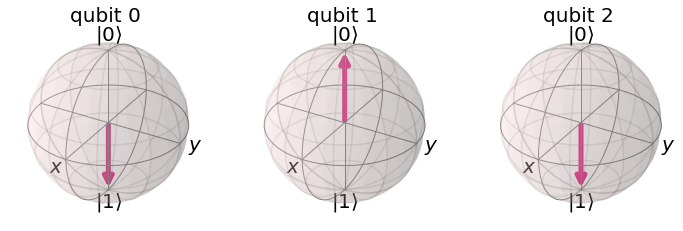

In [5]:
sv_sim = Aer.get_backend("statevector_simulator")
qobj = assemble(qc)
statevector = sv_sim.run(qobj).result().get_statevector()
plot_bloch_multivector(statevector)

 We can see that the prepared state is in $|1\:0\;1\rangle$, so we would hope that the output has the highest probability for this value 

In [6]:
# Define inverse qft function
def inverse_qft(circuit, n):
    qft_circ = qft(QuantumCircuit(n), n)
    invqft_circ = qft_circ.inverse()
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose()

### Fourier Transformed State $|\widetilde{5}\rangle$

In [7]:
state_num = 5
nqubits = 3
qc = QuantumCircuit(nqubits)
for qubit in range(nqubits):
    qc.h(qubit)
qc.p(state_num*pi/4,0)
qc.p(state_num*pi/2,1)
qc.p(state_num*pi,2)

qc.draw()

┌───┐┌─────────┐
q_0: ┤ H ├┤ P(5π/4) ├
     ├───┤├─────────┤
q_1: ┤ H ├┤ P(5π/2) ├
     ├───┤└┬───────┬┘
q_2: ┤ H ├─┤ P(5π) ├─
     └───┘ └───────┘

d:\python\lib\site-packages\qiskit\visualization\bloch.py:69: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


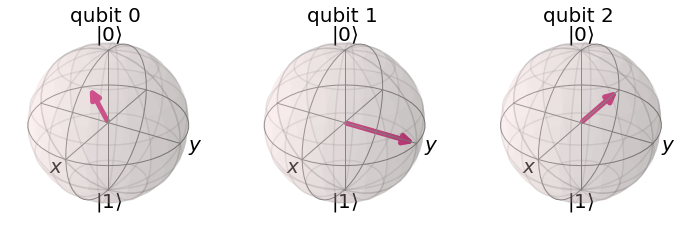

In [8]:
sv_sim = Aer.get_backend("statevector_simulator")
qobj = assemble(qc)
statevector = sv_sim.run(qobj).result().get_statevector()
plot_bloch_multivector(statevector)

In [9]:
qc = inverse_qft(qc,nqubits)
qc.draw()

┌─────────┐┌─────────────┐   ┌───┐                                        
q_0: ┤ U2(0,π) ├┤ U(0,0,5π/4) ├─X─┤ H ├─■────────────────────────■─────────────
     ├─────────┤├─────────────┤ │ └───┘ │P(-π/2) ┌───┐           │             
q_1: ┤ U2(0,π) ├┤ U(0,0,5π/2) ├─┼───────■────────┤ H ├─■─────────┼─────────────
     ├─────────┤└┬───────────┬┘ │                └───┘ │P(-π/2)  │P(-π/4) ┌───┐
q_2: ┤ U2(0,π) ├─┤ U(0,0,5π) ├──X──────────────────────■─────────■────────┤ H ├
     └─────────┘ └───────────┘                                            └───┘

In [10]:
qc.measure_all()
qc.draw()

┌─────────┐┌─────────────┐   ┌───┐                                   »
   q_0: ┤ U2(0,π) ├┤ U(0,0,5π/4) ├─X─┤ H ├─■────────────────────────■────────»
        ├─────────┤├─────────────┤ │ └───┘ │P(-π/2) ┌───┐           │        »
   q_1: ┤ U2(0,π) ├┤ U(0,0,5π/2) ├─┼───────■────────┤ H ├─■─────────┼────────»
        ├─────────┤└┬───────────┬┘ │                └───┘ │P(-π/2)  │P(-π/4) »
   q_2: ┤ U2(0,π) ├─┤ U(0,0,5π) ├──X──────────────────────■─────────■────────»
        └─────────┘ └───────────┘                                            »
meas: 3/═════════════════════════════════════════════════════════════════════»
                                                                             »
«              ░ ┌─┐      
«   q_0: ──────░─┤M├──────
«              ░ └╥┘┌─┐   
«   q_1: ──────░──╫─┤M├───
«        ┌───┐ ░  ║ └╥┘┌─┐
«   q_2: ┤ H ├─░──╫──╫─┤M├
«        └───┘ ░  ║  ║ └╥┘
«meas: 3/═════════╩══╩══╩═
«                 0  1  2

In [11]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= nqubits 
                                      and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)
shots = 2048
transpiled_qc = transpile(qc, backend, optimization_level=3)
qobj = assemble(transpiled_qc, shots=shots)
job = backend.run(qobj)
job_monitor(job)

least busy backend:  ibmq_santiago


<ipython-input-11-b61ff2924c64>:12: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj)


Job Status: job has successfully run


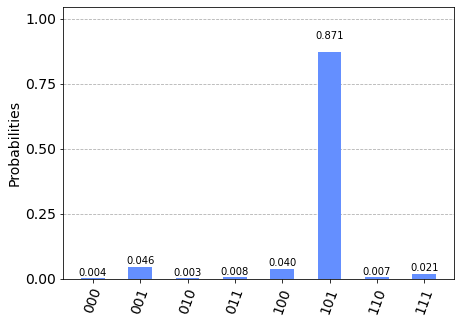

In [12]:
count = job.result().get_counts()
plot_histogram(count)


### Expected:
$|101\rangle$
### Calculated:
$|101\rangle$

### Result:
YAY! It worked